In [1]:
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "07_training/07a_ingest.ipynb"
_nb_title = "Writing an efficient ingest Loop"

### no need to change any of this
_nb_safeloc = _nb_loc.replace('/', '%2F')
md("""
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name={1}&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F{2}&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F{2}">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
""".format(_nb_loc, _nb_title, _nb_safeloc))


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Writing an efficient ingest Loop&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F06_preprocessing%2F07a_ingest.ipynb&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F06_preprocessing%2F07a_ingest.ipynb">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/06_preprocessing/07a_ingest.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/06_preprocessing/07a_ingest.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/06_preprocessing/07a_ingest.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


# Efficient Ingest

In this notebook, we improve the training performance of the model.

## Enable GPU and set up helper functions

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [2]:
import tensorflow as tf
print('TensorFlow version' + tf.version.VERSION)
print('Built with GPU support? ' + ('Yes!' if tf.test.is_built_with_cuda() else 'Noooo!'))
print('There are {} GPUs'.format(len(tf.config.experimental.list_physical_devices("GPU"))))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow version2.3.1
Built with GPU support? Yes!
There are 2 GPUs
Found GPU at: /device:GPU:0


## Original code

This is the original code, from [../06_preprocessing/06e_colordistortion.ipynb](../06_preprocessing/06e_colordistortion.ipynb)

We have a few variations of creating a preprocessed dataset.

In [30]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'    

from tensorflow.data.experimental import AUTOTUNE

IMG_HEIGHT = 448 # note *twice* what we used to have
IMG_WIDTH = 448
IMG_CHANNELS = 3
CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()

def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])
    
class _Preprocessor:    
    def __init__(self):
        # nothing to initialize
        pass
    
    def read_from_tfr(self, proto):
        feature_description = {
            'image': tf.io.VarLenFeature(tf.float32),
            'shape': tf.io.VarLenFeature(tf.int64),
            'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        }
        rec = tf.io.parse_single_example(
            proto, feature_description
        )
        shape = tf.sparse.to_dense(rec['shape'])
        img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
        label_int = rec['label_int']
        return img, label_int
    
    def read_from_jpegfile(self, filename):
        # same code as in 05_create_dataset/jpeg_to_tfrecord.py
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
      
    def preprocess(self, img):
        return tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)

def create_preproc_dataset_plain(pattern):
    preproc = _Preprocessor()
    trainds = tf.data.TFRecordDataset(
        [filename for filename in tf.io.gfile.glob(pattern)],
        compression_type='GZIP'
    ).map(preproc.read_from_tfr).map(
        lambda img, label: (preproc.preprocess(img), label)
    )                             
    return trainds

# note: addition of AUTOTUNE to the map() calls
def create_preproc_dataset_parallelmap(pattern):
    preproc = _Preprocessor()
    def _preproc_img_label(img, label):
        return (preproc.preprocess(img), label)
    trainds = (
        tf.data.TFRecordDataset(
            [filename for filename in tf.io.gfile.glob(pattern)],
            compression_type='GZIP'
        )
        .map(preproc.read_from_tfr, num_parallel_calls=AUTOTUNE)
        .map(_preproc_img_label, num_parallel_calls=AUTOTUNE)
    )
    return trainds

# note: splits the files into two halves and interleaves datasets
def create_preproc_dataset_interleave(pattern, num_parallel=None):
    preproc = _Preprocessor()
    files = [filename for filename in tf.io.gfile.glob(pattern)]
    if len(files) > 1:
        print("Interleaving the reading of {} files.".format(len(files)))
        def _create_half_ds(x):
            if x == 0:
                half = files[:(len(files)//2)]
            else:
                half = files[(len(files)//2):]
            return tf.data.TFRecordDataset(half,
                                          compression_type='GZIP')
        trainds = tf.data.Dataset.range(2).interleave(
            _create_half_ds, num_parallel_calls=AUTOTUNE)
    else:
        trainds = tf.data.TFRecordDataset(files,
                                         compression_type='GZIP')
    def _preproc_img_label(img, label):
        return (preproc.preprocess(img), label)
    
    trainds = (trainds
               .map(preproc.read_from_tfr, num_parallel_calls=num_parallel)
               .map(_preproc_img_label, num_parallel_calls=num_parallel)
              )
    return trainds

def create_preproc_image(filename):
    preproc = _Preprocessor()
    img = preproc.read_from_jpegfile(filename)
    return preproc.preprocess(img)

class RandomColorDistortion(tf.keras.layers.Layer):
    def __init__(self, contrast_range=[0.5, 1.5], 
                 brightness_delta=[-0.2, 0.2], **kwargs):
        super(RandomColorDistortion, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brightness_delta = brightness_delta
    
    def call(self, images, training=None):
        if not training:
            return images
        
        contrast = np.random.uniform(
            self.contrast_range[0], self.contrast_range[1])
        brightness = np.random.uniform(
            self.brightness_delta[0], self.brightness_delta[1])
        
        images = tf.image.adjust_contrast(images, contrast)
        images = tf.image.adjust_brightness(images, brightness)
        images = tf.clip_by_value(images, 0, 1)
        return images

## Speeding up the reading of data

To try it out, we'll simply read through the data several times and compute some quantity on the images.

In [4]:
def loop_through_dataset(ds, nepochs):
    lowest_mean = tf.constant(1.)
    for epoch in range(nepochs):
        thresh = np.random.uniform(0.3, 0.7) # random threshold
        count = 0
        sumsofar = tf.constant(0.)
        for (img, label) in ds:
            # mean of channel values > thresh
            mean = tf.reduce_mean(tf.where(img > thresh, img, 0))
            sumsofar = sumsofar + mean
            count = count + 1
            if count%100 == 0:
                print('.', end='')
        mean = sumsofar/count
        print(mean)
        if mean < lowest_mean:
            lowest_mean = mean
    return lowest_mean

In [31]:
PATTERN_SUFFIX, NUM_EPOCHS = '-0000[01]-*', 2 # 2 files, 2 epochs
#PATTERN_SUFFIX, NUM_EPOCHS = '-*', 20 # 16 files, 20 epochs

In [6]:
%%time
ds = create_preproc_dataset_plain(
    'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX
)
loop_through_dataset(ds, NUM_EPOCHS)

...tf.Tensor(0.22762734, shape=(), dtype=float32)
...tf.Tensor(0.21017572, shape=(), dtype=float32)
CPU times: user 7.03 s, sys: 500 ms, total: 7.53 s
Wall time: 7.99 s


<tf.Tensor: shape=(), dtype=float32, numpy=0.21017572>

In [7]:
%%time
# parallel map
ds = create_preproc_dataset_parallelmap(
    'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX
)
loop_through_dataset(ds, NUM_EPOCHS)

...tf.Tensor(0.14244522, shape=(), dtype=float32)
...tf.Tensor(0.18533988, shape=(), dtype=float32)
CPU times: user 7.93 s, sys: 375 ms, total: 8.3 s
Wall time: 5.94 s


<tf.Tensor: shape=(), dtype=float32, numpy=0.14244522>

In [32]:
%%time
# with interleave
ds = create_preproc_dataset_interleave(
    'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX,
    num_parallel=None
)
loop_through_dataset(ds, NUM_EPOCHS)

Interleaving the reading of 2 files.
first half
second half
...tf.Tensor(0.12316246, shape=(), dtype=float32)
...tf.Tensor(0.15402032, shape=(), dtype=float32)
CPU times: user 7.86 s, sys: 497 ms, total: 8.35 s
Wall time: 5.29 s


<tf.Tensor: shape=(), dtype=float32, numpy=0.12316246>

In [9]:
%%time
# with interleave and parallel mpas
ds = create_preproc_dataset_interleave(
    'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX,
    num_parallel=AUTOTUNE
)
loop_through_dataset(ds, NUM_EPOCHS)

Interleaving the reading of 2 files.
...tf.Tensor(0.18058446, shape=(), dtype=float32)
...tf.Tensor(0.14600855, shape=(), dtype=float32)
CPU times: user 7.99 s, sys: 443 ms, total: 8.44 s
Wall time: 5.23 s


<tf.Tensor: shape=(), dtype=float32, numpy=0.14600855>

When I did this, this is what I got:

| Method                 | CPU time    | Wall time    |
| ---------------------- | ----------- | ------------ |
| Plain                  | 7.53s       | 7.99s        |
| Parallel Map           | 8.30s       | 5.94s        |
| Interleave             | 8.60s       | 5.47s        |
| Interleave+Parallel Map| 8.44s       | 5.23s        |

## ML model

The computation above was pretty cheap involving merely adding up all the pixel values.
What happens if we need a bit more complexity (gradient calc, etc.)?

In [14]:
def train_simple_model(ds, nepochs):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(
            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        #tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
    model.fit(ds, epochs=nepochs)

In [15]:
%%time
ds = create_preproc_dataset_plain(
    'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX
).batch(1)
train_simple_model(ds, NUM_EPOCHS)

Epoch 1/2
359/359 [==============================] - 4s 11ms/step - loss: 384.5950 - accuracy: 0.2841
Epoch 2/2
359/359 [==============================] - 4s 11ms/step - loss: 260.8144 - accuracy: 0.3983
CPU times: user 9.12 s, sys: 796 ms, total: 9.91 s
Wall time: 9.39 s


In [16]:
%%time
# parallel map
ds = create_preproc_dataset_parallelmap(
    'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX
).batch(1)
train_simple_model(ds, NUM_EPOCHS)

Epoch 1/2
359/359 [==============================] - 4s 10ms/step - loss: 378.1755 - accuracy: 0.2646
Epoch 2/2
359/359 [==============================] - 4s 10ms/step - loss: 277.4931 - accuracy: 0.4067
CPU times: user 9.97 s, sys: 718 ms, total: 10.7 s
Wall time: 8.17 s


In [17]:
%%time
# with interleave
ds = create_preproc_dataset_interleave(
    'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX,
    num_parallel=None
).batch(1)
train_simple_model(ds, NUM_EPOCHS)

Interleaving the reading of 2 files.
Epoch 1/2
359/359 [==============================] - 3s 9ms/step - loss: 359.4355 - accuracy: 0.3008
Epoch 2/2
359/359 [==============================] - 3s 9ms/step - loss: 296.0292 - accuracy: 0.3928
CPU times: user 9.7 s, sys: 825 ms, total: 10.5 s
Wall time: 7.54 s


In [18]:
%%time
# with interleave and parallel mpas
ds = create_preproc_dataset_interleave(
    'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX,
    num_parallel=AUTOTUNE
).batch(1)
train_simple_model(ds, NUM_EPOCHS)

Interleaving the reading of 2 files.
Epoch 1/2
359/359 [==============================] - 3s 9ms/step - loss: 403.3262 - accuracy: 0.2423
Epoch 2/2
359/359 [==============================] - 3s 8ms/step - loss: 260.8356 - accuracy: 0.4290
CPU times: user 9.6 s, sys: 728 ms, total: 10.3 s
Wall time: 7.17 s


We note that the improvement remains:

| Method                 | CPU time    | Wall time    |
| -----------------------| ----------- | ------------ |
| Plain                  | 9.91s        | 9.39s        |
| Parallel Map           | 10.7s        | 8.17s        |
| Interleave             | 10.5s        | 7.54s        |
| Interleave+Parallel Map| 10.3s        | 7.17s        |

## Speeding up the handling of data

In [19]:
# alias to the more efficient one
def create_preproc_dataset(pattern):
    return create_preproc_dataset_interleave(pattern, num_parallel=AUTOTUNE)

In [20]:
%%time
# add prefetching
ds = create_preproc_dataset(
    'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX
).prefetch(AUTOTUNE).batch(1)
train_simple_model(ds, NUM_EPOCHS)

Interleaving the reading of 2 files.
Epoch 1/2
359/359 [==============================] - 3s 9ms/step - loss: 387.4389 - accuracy: 0.2813
Epoch 2/2
359/359 [==============================] - 3s 9ms/step - loss: 279.8046 - accuracy: 0.3760
CPU times: user 10.5 s, sys: 899 ms, total: 11.4 s
Wall time: 8.09 s


In [26]:
%%time
# Add batching of different sizes
ds = create_preproc_dataset(
    'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX
).prefetch(AUTOTUNE).batch(8)
train_simple_model(ds, NUM_EPOCHS)

Interleaving the reading of 2 files.
Epoch 1/2
45/45 [==============================] - 3s 60ms/step - loss: 113.6279 - accuracy: 0.2702
Epoch 2/2
45/45 [==============================] - 3s 56ms/step - loss: 120.0435 - accuracy: 0.2758
CPU times: user 8.97 s, sys: 590 ms, total: 9.56 s
Wall time: 6.9 s


In [21]:
%%time
# Add batching of different sizes
ds = create_preproc_dataset(
    'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX
).prefetch(AUTOTUNE).batch(16)
train_simple_model(ds, NUM_EPOCHS)

Interleaving the reading of 2 files.
Epoch 1/2
23/23 [==============================] - 3s 110ms/step - loss: 97.3240 - accuracy: 0.2507
Epoch 2/2
23/23 [==============================] - 2s 105ms/step - loss: 41.4950 - accuracy: 0.3900
CPU times: user 8.97 s, sys: 939 ms, total: 9.9 s
Wall time: 6.7 s


In [22]:
%%time
# Add batching of different sizes
ds = create_preproc_dataset(
    'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX
).prefetch(AUTOTUNE).batch(32)
train_simple_model(ds, NUM_EPOCHS)

Interleaving the reading of 2 files.
Epoch 1/2
12/12 [==============================] - 2s 187ms/step - loss: 121.8208 - accuracy: 0.2423
Epoch 2/2
12/12 [==============================] - 2s 185ms/step - loss: 51.0977 - accuracy: 0.3259
CPU times: user 8.78 s, sys: 902 ms, total: 9.68 s
Wall time: 6.37 s


In [23]:
%%time
# add caching: always do this optimization last.
ds = create_preproc_dataset(
    'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX
).cache().batch(32)
train_simple_model(ds, NUM_EPOCHS)

Interleaving the reading of 2 files.
Epoch 1/2
12/12 [==============================] - 3s 213ms/step - loss: 106.7971 - accuracy: 0.2423
Epoch 2/2
12/12 [==============================] - 1s 47ms/step - loss: 66.2376 - accuracy: 0.3203
CPU times: user 5.16 s, sys: 1 s, total: 6.16 s
Wall time: 4.36 s


In [24]:
%%time
# add caching: always do this optimization last.
ds = create_preproc_dataset(
    'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX
).prefetch(AUTOTUNE).cache().batch(32)
train_simple_model(ds, NUM_EPOCHS)

Interleaving the reading of 2 files.
Epoch 1/2
12/12 [==============================] - 2s 192ms/step - loss: 126.8334 - accuracy: 0.2340
Epoch 2/2
12/12 [==============================] - 1s 45ms/step - loss: 51.4512 - accuracy: 0.3287
CPU times: user 5.01 s, sys: 756 ms, total: 5.76 s
Wall time: 4.04 s


In [25]:
%%time
# add caching: always do this optimization last.
ds = create_preproc_dataset(
    'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX
).cache().prefetch(AUTOTUNE).batch(32)
train_simple_model(ds, NUM_EPOCHS)

Interleaving the reading of 2 files.
Epoch 1/2
12/12 [==============================] - 2s 208ms/step - loss: 148.2066 - accuracy: 0.2507
Epoch 2/2
12/12 [==============================] - 1s 44ms/step - loss: 71.6666 - accuracy: 0.3064
CPU times: user 4.95 s, sys: 692 ms, total: 5.65 s
Wall time: 4.19 s


Adding to the previous table:

| Method                 | CPU time    | Wall time    |
| -----------------------| ----------- | ------------ |
| Plain                  | 9.91s        | 9.39s        |
| Parallel Map           | 10.7s        | 8.17s        |
| Interleave             | 10.5s        | 7.54s        |
| Interleave+Parallel Map| 10.3s        | 7.17s        |
| Interleave + Parallel, and then adding:         | - | - |
| Prefetch           | 11.4s       | 8.09s        |
| Batch size  8      | 9.56s       | 6.90s        |
| Batch size 16      | 9.90s       | 6.70s        |
| Batch size 32      | 9.68s       | 6.37s        |
| Interleave + Parallel + batchsize 32, and then adding: | - | - |
| Cache              | 6.16s       | 4.36s        |
| Prefetch + Cache   | 5.76s       | 4.04s        |
| Cache + Prefetch   | 5.65s       | 4.19s        |

So, the best option is:
<pre>
ds = create_preproc_dataset_interleave(pattern, num_parallel=AUTOTUNE).prefetch(AUTOTUNE).cache().batch(32)
</pre>

## Apply efficiency improvements

Interleaving, parallel calls, prefetch, batching

Caching is not a good idea on large datasets.

In [27]:
# PATTERN_SUFFIX, NUM_EPOCHS = '-0000[0123]-*', 3 # small
PATTERN_SUFFIX, NUM_EPOCHS = '-*', 20 # full

In [28]:
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)
    
    train_dataset = create_preproc_dataset_interleave(
        'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX,
        num_parallel=AUTOTUNE
    ).prefetch(AUTOTUNE).batch(batch_size)
    eval_dataset = create_preproc_dataset_interleave(
        'gs://practical-ml-vision-book/flowers_tfr/valid' + PATTERN_SUFFIX,
        num_parallel=AUTOTUNE
    ).prefetch(AUTOTUNE).batch(batch_size)

    layers = [
      tf.keras.layers.experimental.preprocessing.RandomCrop(
          height=IMG_HEIGHT//2, width=IMG_WIDTH//2,
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          name='random/center_crop'
      ),
      tf.keras.layers.experimental.preprocessing.RandomFlip(
          mode='horizontal',
          name='random_lr_flip/none'
      ),
      RandomColorDistortion(name='random_contrast_brightness/none'),
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
    ]

    model = tf.keras.Sequential(layers, name='flower_classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=NUM_EPOCHS)
    training_plot(['loss', 'accuracy'], history)
    return model


Interleaving the reading of 16 files.
Interleaving the reading of 2 files.
Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random/center_crop (RandomCr (None, 224, 224, 3)       0         
_________________________________________________________________
random_lr_flip/none (RandomF (None, 224, 224, 3)       0         
_________________________________________________________________
random_contrast_brightness/n (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_embedding (KerasLa (None, 1280)              2257984   
_________________________________________________________________
dense_hidden (Dense)         (None, 16)                20496     
_________________________________________________________________
flower_prob (Dense)          (None, 5)                 85        
Total params: 2,278,565
Trainable pa

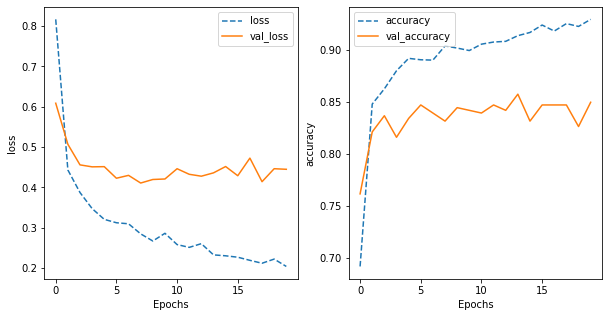

In [29]:
model = train_and_evaluate()

With these efficiencies, an epoch takes around 30s (compared to 120s before).

## Save model, then load it to make predictions

This way, we don't have to have the model in memory

In [ ]:
import os, shutil
shutil.rmtree('export', ignore_errors=True)
os.mkdir('export')
model.save('export/flowers_model')

In [ ]:
!ls export/flowers_model

In [ ]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir export/flowers_model

In [ ]:
# Call model.predict() on a few images in evaluation dataset
def plot_predictions(model, pattern):
    dataset = create_preproc_dataset_plain(pattern)
    f, ax = plt.subplots(3, 5, figsize=(25,15))
    for idx, (img, label) in enumerate(dataset.take(15)):
        ax[idx//5, idx%5].imshow((img.numpy()));
        batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        batch_pred = model.predict(batch_image)
        pred = batch_pred[0]
        label = CLASS_NAMES[label.numpy()]
        pred_label_index = tf.math.argmax(pred).numpy()
        pred_label = CLASS_NAMES[pred_label_index]
        prob = pred[pred_label_index]
        ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

serving_model = tf.keras.models.load_model('export/flowers_model')
plot_predictions(serving_model, 'gs://practical-ml-vision-book/flowers_tfr/valid-*')

In [ ]:
## but actually, for prediction, we won't have TensorFlow Records.
## this is how we'd predict for individual images
## (actually, we'll create a serving function: we'll look at that in a later chapter)
filenames = [
    'gs://cloud-ml-data/img/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://cloud-ml-data/img/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://cloud-ml-data/img/flower_photos/dandelion/98992760_53ed1d26a9.jpg',
    'gs://cloud-ml-data/img/flower_photos/dandelion/9939430464_5f5861ebab.jpg',
    'gs://cloud-ml-data/img/flower_photos/dandelion/9965757055_ff01b5ee6f_n.jpg'
]
label = 'dandelion'
input_images = [create_preproc_image(f) for f in filenames]
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, img in enumerate(input_images):
    ax[idx].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = serving_model.predict(batch_image)
    pred = batch_pred[0]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

## License
Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.